In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import xarray as xr

from rate_model import RateModelWC
from utils import json_safe

#### Generate sample

In [132]:
SEED = 113
np.random.seed(SEED)

# Model params
N = 2
model_par = dict(tau=1, rmax=10, gain_slope=0.5, gain_center=0)
sim_par = {'dt': 0.25, 'nsteps': 100}

# Sample size
n_model_gens = 512
n_point_gens = 32

# Sampling parameters
sample_par = {
    'rand_type': {'w': 'uni', 'h0': 'uni'},
    'w_sigma': 1,
    'sample_points_by': 'r0',
    'h0_sigma': 2,
    'r0_range': (0.1, model_par['rmax'] - 0.1)
}

# Create xarray dataset
X = xr.Dataset(
    {
        'W': (['model', 'pop_in', 'pop'], np.zeros((n_model_gens, N, N))),
        'H': (['model', 'point', 'pop'], np.zeros((n_model_gens, n_point_gens, N))),
        'R': (['model', 'point', 'pop'], np.zeros((n_model_gens, n_point_gens, N))),
        'L_re': (['model', 'point', 'pop'], np.zeros((n_model_gens, n_point_gens, N))),
        'L_im': (['model', 'point', 'pop'], np.zeros((n_model_gens, n_point_gens, N))),
    },
    coords={
        'model': np.arange(n_model_gens),
        'point': np.arange(n_point_gens),
        'pop': np.arange(N),
        'pop_in': np.arange(N)
    }
)
# Metadata
meta = {
    'seed': SEED,
    'npops': N,
    'n_model_gens': n_model_gens,
    'n_point_gens': n_point_gens,
    **sample_par, **model_par, **sim_par
}
X.attrs["meta"] = json.dumps(json_safe(meta))

# For eigenvalues
""" L = xr.DataArray(
    data=np.zeros((n_model_gens, n_point_gens, N),
                  dtype=np.complex128),
    dims = ['model', 'point', 'n'],
    coords={'model': np.arange(n_model_gens),
            'point': np.arange(n_point_gens),
            'n': np.arange(N)}
) """

for n in range(n_model_gens):
    if n % 25 == 0:
        print(f'Model: {n + 1}/{n_model_gens}', flush=True)

    # Sample weights
    wtype, ws = sample_par['rand_type']['w'], sample_par['w_sigma']
    if wtype == 'norm':
        W = ws * np.random.randn(N, N)
    elif wtype == 'uni':
        W = ws * (2 * np.random.rand(N, N) - 1)
    else:
        raise ValueError(f"Unknown random type for weights: {wtype}")
    X['W'].loc[{'model': n}] = W

    # Initialize model
    model = RateModelWC(W, **model_par)

    for m in (range(n_point_gens)):

        # Sample h0, derive r0
        if sample_par['sample_points_by'] == 'h0':
            # Sample h0
            htype, hs = sample_par['rand_type']['h0'], sample_par['h0_sigma']
            if htype == 'norm':
                h0 = hs * np.random.randn(N, 1)
            elif htype == 'uni':
                h0 = hs * (2 * np.random.rand(N, 1) - 1)
            else:
                raise ValueError(f"Unknown random type for h0: {htype}")
            # Run the model
            r0 = model.run(h0, r0=np.zeros((N, 1)), **sim_par)
        
        # Sample r0, derive h0
        elif sample_par['sample_points_by'] == 'r0':
            # Sample r0
            r0_range = sample_par['r0_range']
            r0 = np.random.uniform(r0_range[0], r0_range[1], (N, 1))
            # Derive h0
            h0 = model.r0_to_h0(r0)           

        # Store r0 and h0
        X['H'].loc[{'model': n, 'point': m}] = h0.ravel()
        X['R'].loc[{'model': n, 'point': m}] = r0.ravel()

        # Eigenvalues
        J = model.get_J(r0, h0)
        l = np.linalg.eigvals(J)
        X['L_re'].loc[{'model': n, 'point': m}] = np.real(l)
        X['L_im'].loc[{'model': n, 'point': m}] = np.imag(l)


Model: 1/512


Model: 26/512
Model: 51/512
Model: 76/512
Model: 101/512
Model: 126/512
Model: 151/512
Model: 176/512
Model: 201/512
Model: 226/512
Model: 251/512
Model: 276/512
Model: 301/512
Model: 326/512
Model: 351/512
Model: 376/512
Model: 401/512
Model: 426/512
Model: 451/512
Model: 476/512
Model: 501/512


#### Test $r_0$, $h_0$ match

In [170]:
# Randomly select indices for model and point
model_id = np.random.randint(0, n_model_gens)
point_id = np.random.randint(0, n_point_gens)

# Extract W, r0, and h0 from X
W = X['W'].sel(model=model_id).values
r0 = X['R'].sel(model=model_id, point=point_id).values.reshape(-1, 1)
h0 = X['H'].sel(model=model_id, point=point_id).values.reshape(-1, 1)
lre = X['L_re'].sel(model=model_id, point=point_id).values.reshape(-1, 1)

# Initialize the model with the randomly chosen W
model = RateModelWC(W, **model_par)

# Run the model with the chosen h0
r0_hat = model.run(h0, r0=np.zeros((N, 1)), **sim_par)

# Compare r0_hat with r0
print("Original r0:", r0.ravel())
print("Computed r0_hat:", r0_hat.ravel())
print("Difference:", (r0_hat - r0).ravel())
print("Re(L):", lre.ravel())


Original r0: [4.83950471 3.46419514]
Computed r0_hat: [2.70731701 5.32607204]
Difference: [-2.1321877  1.8618769]
Re(L): [ 0.04494281 -1.06183197]


#### Explore Jacobian eigenvalues

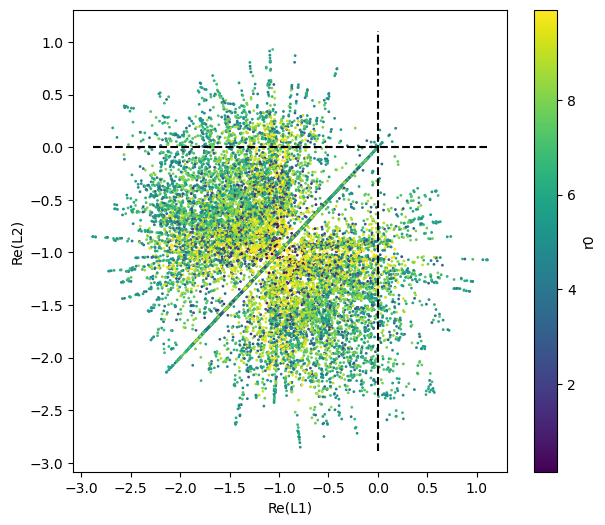

In [172]:
plt.figure(figsize=(7, 6))

Lre = X['L_re'].values.reshape((-1, N))
R0 = X['R'].values.reshape((-1, N))

Lmin = Lre.ravel().min()
Lmax = Lre.ravel().max()

cc = np.max(R0, axis=1)

plt.scatter(np.real(Lre[:, 0]), np.real(Lre[:, 1]), c=cc,
            cmap='viridis', s=1)
plt.plot([Lmin, Lmax], [0, 0], 'k--')
plt.plot([0, 0], [Lmin, Lmax], 'k--')
plt.xlabel('Re(L1)')
plt.ylabel('Re(L2)')
plt.colorbar(label='r0')


#### Explore timecourse for various eigenvalues

Text(0.5, 1.0, 're_max=-0.055, im=0.51')

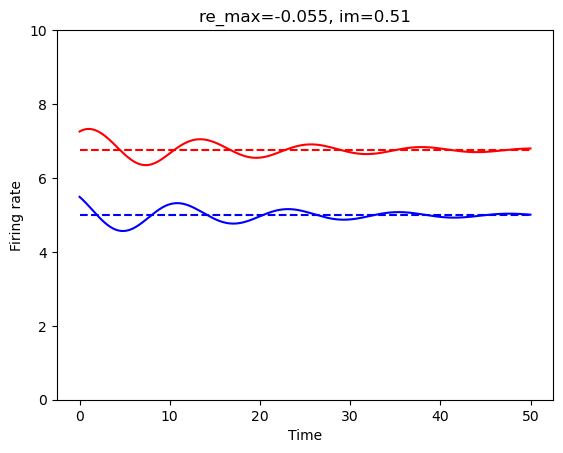

In [189]:
# Define the ranges for real and imaginary parts
#re_range = (0, np.inf)
#re_range = (-np.inf, 0)
re_range = (-0.1, 0)
#im_range = (0.0, np.inf)
im_range = (0.5, np.inf)

# Find indices of points where the max of Re(L) lies within re_range
# and Im(L) lies within im_range
mask = (
    (X['L_re'].max(dim='pop') >= re_range[0]) &
    (X['L_re'].max(dim='pop') <= re_range[1]) &
    (X['L_im'].max(dim='pop') >= im_range[0]) &
    (X['L_im'].max(dim='pop') <= im_range[1])
)
model_idx, point_idx = np.where(mask.values)

# Randomly select one of the valid (model, point) pairs
rand_id = np.random.choice(len(model_idx))
model_id, point_id = int(model_idx[rand_id]), int(point_idx[rand_id])
cc = dict(model=model_id, point=point_id)

# Extract W, r0, and h0 for the selected point
W = X['W'].sel(model=model_id).values
h0 = X['H'].sel(cc).values.reshape(-1, 1)
r0 = X['R'].sel(cc).values.reshape(-1, 1)

# Extract eigenvalues
l_re = X['L_re'].sel(cc).values
l_im = X['L_im'].sel(cc).values
l = l_re + 1j * l_im

# Initialize the model with the selected W
model = RateModelWC(W, **model_par)
model.sim_res_type = 'full'

# Simulate the model with the selected h0
rstart = r0 + 0.5
T = 50
dt = 0.02
R = model.run(h0, r0=rstart, dt=dt, nsteps=int(T / dt))

plt.figure()
cols = ['b', 'r']
for pop in range(N):
    plt.plot(R.time, R.sel(pop=pop), cols[pop])
    plt.plot([R.time.min(), R.time.max()], [r0[pop]] * 2, cols[pop] + '--')
plt.xlabel('Time')
plt.ylabel('Firing rate')
plt.ylim(0, 10)
plt.title(f're_max={np.real(l).max():.02}, im={np.imag(l).max():.02}')

#### Save the sample

In [190]:
dt, nsteps = sim_par['dt'], sim_par['nsteps']

ws, wtype = sample_par['w_sigma'], sample_par['rand_type']['w']
wstr = f'ws_{ws}_{wtype}'

if sample_par['sample_points_by'] == 'h0':
    hs, htype = sample_par['h0_sigma'], sample_par['rand_type']['h0']
    inp_str = f'hs_{hs}_{htype}'
elif sample_par['sample_points_by'] == 'r0':
    r_range = sample_par['r0_range']
    inp_str = f'r_{r_range[0]}_{r_range[1]}'

fname_out = (f'rates_npops_{N}_nmodels_{n_model_gens}_npts_{n_point_gens}_seed_{SEED}_'
             f'{wstr}_{inp_str}_dt_{dt}_nt_{nsteps}.nc')

# Save the dataset to a NetCDF file
X.to_netcdf(Path().resolve().parent / 'data' / fname_out)

#data = xr.open_dataset('data/training_data.nc')
#print(data)
#data.close()